# Customer Churn Prediction - Machine Learning Model

## Project Overview
This notebook implements a complete Machine Learning pipeline to predict customer churn for an e-commerce business. The model identifies customers who are likely to discontinue using the company's services, enabling proactive retention strategies.

## Objectives
- Build a Machine Learning Prediction model to predict Customer Churn
- Handle imbalanced datasets using SMOTE
- Evaluate models using appropriate metrics
- Generate Confusion Matrix and ROC Curve visualizations
- Explain evaluation metrics and visualizations


In [24]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


## Step 1: Download Dataset

Download the dataset from Kaggle using `kagglehub`.


In [25]:
# Download dataset from Kaggle
print("=" * 60)
print("STEP 1: Downloading Dataset")
print("=" * 60)

try:
    # Download latest version
    path = kagglehub.dataset_download("ankitverma2010/ecommerce-customer-churn-analysis-and-prediction")
    print(f"✓ Dataset downloaded successfully!")
    print(f"Path to dataset files: {path}")
    
    # Find data files (CSV or Excel) in the downloaded directory
    data_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(('.csv', '.xlsx', '.xls')):
                data_files.append(os.path.join(root, file))
    
    if data_files:
        print(f"\nFound data files:")
        for data_file in data_files:
            print(f"  - {data_file}")
        file_path = data_files[0]  # Use first data file
    else:
        raise FileNotFoundError("No CSV or Excel files found in downloaded dataset")
        
except Exception as e:
    print(f"Error downloading dataset: {e}")
    raise


STEP 1: Downloading Dataset
✓ Dataset downloaded successfully!
Path to dataset files: C:\Users\gupta\.cache\kagglehub\datasets\ankitverma2010\ecommerce-customer-churn-analysis-and-prediction\versions\1

Found data files:
  - C:\Users\gupta\.cache\kagglehub\datasets\ankitverma2010\ecommerce-customer-churn-analysis-and-prediction\versions\1\E Commerce Dataset.xlsx


## Step 2: Load and Explore Data

Load the dataset and explore its structure, missing values, and basic statistics.


In [26]:
# Load data based on file extension
print("\n" + "=" * 60)
print("STEP 2: Loading and Exploring Data")
print("=" * 60)

if file_path.endswith('.csv'):
    df = pd.read_csv(file_path)
elif file_path.endswith(('.xlsx', '.xls')):
    # Try to find the data sheet (skip metadata sheets)
    xl_file = pd.ExcelFile(file_path)
    sheet_names = xl_file.sheet_names
    
    # Look for common data sheet names or use the largest sheet
    data_sheet = None
    for sheet in sheet_names:
        sheet_lower = sheet.lower()
        # Skip metadata/dictionary sheets
        if 'dict' not in sheet_lower and 'meta' not in sheet_lower and 'info' not in sheet_lower:
            # Check if this sheet has substantial data
            test_df = pd.read_excel(file_path, sheet_name=sheet, nrows=5)
            if len(test_df.columns) > 2:  # Has multiple columns (likely data)
                data_sheet = sheet
                break
    
    # If no suitable sheet found, try the largest sheet
    if data_sheet is None:
        max_rows = 0
        for sheet in sheet_names:
            test_df = pd.read_excel(file_path, sheet_name=sheet)
            if len(test_df) > max_rows:
                max_rows = len(test_df)
                data_sheet = sheet
    
    # Load the data sheet
    if data_sheet:
        print(f"\nLoading data from sheet: '{data_sheet}'")
        df = pd.read_excel(file_path, sheet_name=data_sheet)
    else:
        # Fallback to first sheet
        print(f"\nWarning: Could not determine data sheet, using first sheet: '{sheet_names[0]}'")
        df = pd.read_excel(file_path, sheet_name=sheet_names[0])
else:
    raise ValueError(f"Unsupported file format: {file_path}")

print(f"\n✓ Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()



STEP 2: Loading and Exploring Data

Loading data from sheet: 'E Comm'

✓ Data loaded successfully!
Dataset shape: (5630, 20)

First few rows:


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [27]:
# Dataset information
print("Dataset Info:")
df.info()
print("\nMissing values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  Numb

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,1625.385339,0.374240,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,0.000000,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,54222.750000,0.000000,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


## Step 3: Data Cleaning & Preprocessing

Clean the data, handle missing values, encode categorical variables, and identify the target variable.


In [28]:
# Data preprocessing
print("\n" + "=" * 60)
print("STEP 3: Data Cleaning & Preprocessing")
print("=" * 60)

df_processed = df.copy()

# Handle missing values
print("\nHandling missing values...")
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

# Identify target variable
target_candidates = ['churn', 'Churn', 'Churned', 'churned', 'is_churn']
target_col = None
for col in target_candidates:
    if col in df_processed.columns:
        target_col = col
        break

if target_col is None:
    for col in df_processed.columns:
        if df_processed[col].dtype in ['int64', 'float64'] and df_processed[col].nunique() == 2:
            target_col = col
            break

print(f"\n✓ Target variable identified: {target_col}")

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

# Encode categorical variables
print("\nEncoding categorical variables...")
label_encoders = {}
categorical_cols = X.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode target if needed
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    label_encoders['target'] = le_target

# Check class distribution
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y)*100:.2f}%)")

print("\n✓ Data preprocessing completed!")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")



STEP 3: Data Cleaning & Preprocessing

Handling missing values...

✓ Target variable identified: Churn

Encoding categorical variables...

Class distribution:
  Class 0: 4682 (83.16%)
  Class 1: 948 (16.84%)

✓ Data preprocessing completed!
Features shape: (5630, 19)
Target shape: (5630,)


## Step 4: Handle Imbalanced Dataset

Apply SMOTE to balance the dataset and handle class imbalance.


In [29]:
# Handle imbalanced dataset
print("\n" + "=" * 60)
print("STEP 4: Handling Imbalanced Dataset")
print("=" * 60)

print(f"\nOriginal class distribution:")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y)*100:.2f}%)")

imbalance_ratio = min(counts) / max(counts)
print(f"\nImbalance ratio: {imbalance_ratio:.3f}")

if imbalance_ratio < 0.5:
    print(f"\n⚠ Dataset is imbalanced! Applying SMOTE technique...")
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    print(f"\nAfter SMOTE:")
    unique, counts = np.unique(y_balanced, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"  Class {u}: {c} ({c/len(y_balanced)*100:.2f}%)")
    
    print(f"\n✓ Dataset balanced successfully!")
else:
    print("\n✓ Dataset is relatively balanced, no resampling needed.")
    X_balanced, y_balanced = X, y

print(f"\nBalanced dataset shape: {X_balanced.shape}")



STEP 4: Handling Imbalanced Dataset

Original class distribution:
  Class 0: 4682 (83.16%)
  Class 1: 948 (16.84%)

Imbalance ratio: 0.202

⚠ Dataset is imbalanced! Applying SMOTE technique...

After SMOTE:
  Class 0: 4682 (50.00%)
  Class 1: 4682 (50.00%)

✓ Dataset balanced successfully!

Balanced dataset shape: (9364, 19)


## Step 5: Train-Test Split, Feature Scaling & PCA

Split the data, scale features, and apply PCA for dimensionality reduction.


In [30]:
# Split, scale, and apply PCA
print("\n" + "=" * 60)
print("STEP 5: Train-Test Split, Feature Scaling & PCA")
print("=" * 60)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Original number of features: {X_balanced.shape[1]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Data scaled successfully!")

# Apply PCA
print(f"\nApplying PCA (target variance: 95.0%)...")
pca = PCA(n_components=0.95, random_state=42)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

n_components = pca.n_components_
explained_variance = pca.explained_variance_ratio_.sum()

print(f"✓ PCA applied successfully!")
print(f"  Reduced dimensions: {X_balanced.shape[1]} → {n_components}")
print(f"  Explained variance: {explained_variance*100:.2f}%")
print(f"  Variance retained: {explained_variance*100:.2f}%")

print(f"\nFinal feature dimensions:")
print(f"  Training set: {X_train_scaled.shape}")
print(f"  Test set: {X_test_scaled.shape}")



STEP 5: Train-Test Split, Feature Scaling & PCA

Training set: (7491, 19)
Test set: (1873, 19)
Original number of features: 19

✓ Data scaled successfully!

Applying PCA (target variance: 95.0%)...
✓ PCA applied successfully!
  Reduced dimensions: 19 → 17
  Explained variance: 96.65%
  Variance retained: 96.65%

Final feature dimensions:
  Training set: (7491, 17)
  Test set: (1873, 17)


## Step 6: Model Training with Cross-Validation (Random Forest)

Train Random Forest model with GridSearchCV for hyperparameter tuning and cross-validation. Hyperparameters are tuned to prevent overfitting.


In [ ]:
# Train Random Forest model with cross-validation
print("\n" + "=" * 60)
print("STEP 6: Model Training with Cross-Validation (Random Forest)")
print("=" * 60)

# Define Random Forest model optimized for accuracy with minimal overfitting
# Using RandomizedSearchCV for faster, more efficient hyperparameter search
models_config = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'params': {
            'C': [0.1, 0.5, 1.0, 2.0],  # Regularization strength
            'solver': ['lbfgs', 'liblinear']  # Solver algorithms
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'n_estimators': [150, 200, 250],  # More trees for better accuracy
            'max_depth': [6, 8, 10],  # Very shallow trees to minimize overfitting
            'min_samples_split': [20, 30, 40],  # Very high threshold to prevent overfitting
            'min_samples_leaf': [10, 15, 20],  # Very strong regularization
            'max_features': ['sqrt', 'log2']  # Feature diversity
        }
    }
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds for speed
target_accuracy_rf = 0.85
target_accuracy_lr = 0.70
results = {}

for name, config in models_config.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # RandomizedSearchCV for faster hyperparameter tuning
    print("  Performing RandomizedSearchCV for hyperparameter tuning...")
    random_search = RandomizedSearchCV(
        config['model'],
        config['params'],
        n_iter=15, 
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    random_search.fit(X_train_scaled, y_train)
    
    best_model = random_search.best_estimator_
    print(f"  Best parameters: {random_search.best_params_}")
    
    # Cross-validation scores
    print("  Performing cross-validation...")
    cv_scores = cross_val_score(
        best_model, X_train_scaled, y_train,
        cv=cv, scoring='accuracy', n_jobs=-1
    )
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    print(f"  CV Accuracy: {cv_mean:.4f} (+/- {cv_std*2:.4f})")
    
    # Train and test predictions
    y_train_pred = best_model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Overfitting detection
    overfitting_gap = train_accuracy - test_accuracy
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy:  {test_accuracy:.4f}")
    print(f"  Overfitting Gap: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.10:
        print(f"  ⚠ Warning: Potential overfitting detected (gap > 10%)")
    elif overfitting_gap > 0.05:
        print(f"  ⚠ Caution: Moderate overfitting (gap > 5%)")
    else:
        print(f"  ✓ Good generalization (overfitting gap < 5%)")
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': best_model,
        'accuracy': test_accuracy,
        'train_accuracy': train_accuracy,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'overfitting_gap': overfitting_gap,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'best_params': random_search.best_params_
    }
    
    print(f"  Final Test Metrics:")
    print(f"    Accuracy: {test_accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall: {recall:.4f}")
    print(f"    F1-Score: {f1:.4f}")
    print(f"    ROC-AUC: {roc_auc:.4f}")

# Select Random Forest model
print(f"\n{'='*60}")
print("Model Selection (Random Forest)")
print(f"{'='*60}")

best_model_name = 'Random Forest'
best_result = results[best_model_name]

print(f"\n✓ Selected Model: {best_model_name}")
print(f"  Test Accuracy: {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)")
print(f"  CV Mean Accuracy: {best_result['cv_mean']:.4f} (+/- {best_result['cv_std']*2:.4f})")
print(f"  Overfitting Gap: {best_result['overfitting_gap']:.4f}")
print(f"  ROC-AUC: {best_result['roc_auc']:.4f}")

# Check overfitting and suggest improvements if needed
if best_result['overfitting_gap'] > 0.05:
    print(f"\n⚠ Overfitting detected! Consider:")
    print(f"  - Further reducing max_depth")
    print(f"  - Increasing min_samples_split and min_samples_leaf")
    print(f"  - Using max_features='sqrt' or 'log2'")

# Check if target accuracy is achieved
if abs(best_result['accuracy'] - target_accuracy) < 0.02:
    print(f"\n✓ Target accuracy (~87%) achieved!")
else:
    print(f"\n  Current accuracy: {best_result['accuracy']*100:.2f}%, Target: {target_accuracy*100:.2f}%")

# Store best model predictions
y_pred = best_result['y_pred']
y_pred_proba = best_result['y_pred_proba']

# Save models
print(f"\n{'='*60}")
print("Saving Models")
print(f"{'='*60}")

# Save Random Forest model
rf_model_path = 'random_forest_model.pkl'
joblib.dump(results['Random Forest']['model'], rf_model_path)
print(f"✓ Random Forest model saved: {rf_model_path}")

# Save Logistic Regression model
lr_model_path = 'logistic_regression_model.pkl'
joblib.dump(results['Logistic Regression']['model'], lr_model_path)
print(f"✓ Logistic Regression model saved: {lr_model_path}")

# Save scaler and PCA
scaler_path = 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved: {scaler_path}")

if use_pca:
    pca_path = 'pca.pkl'
    joblib.dump(pca, pca_path)

# Save label encoders
if 'label_encoders' in locals() and label_encoders:
    encoders_path = 'label_encoders.pkl'
    joblib.dump(label_encoders, encoders_path)
    print(f"✓ Label encoders saved: {encoders_path}")

# Save model metadata
metadata = {
    'best_model': best_model_name,
    'random_forest': {
        'accuracy': results['Random Forest']['accuracy'],
        'train_accuracy': results['Random Forest']['train_accuracy'],
        'cv_mean': results['Random Forest']['cv_mean'],
        'cv_std': results['Random Forest']['cv_std'],
        'overfitting_gap': results['Random Forest']['overfitting_gap'],
        'roc_auc': results['Random Forest']['roc_auc'],
        'best_params': results['Random Forest']['best_params']
    },
    'logistic_regression': {
        'accuracy': results['Logistic Regression']['accuracy'],
        'train_accuracy': results['Logistic Regression']['train_accuracy'],
        'cv_mean': results['Logistic Regression']['cv_mean'],
        'cv_std': results['Logistic Regression']['cv_std'],
        'overfitting_gap': results['Logistic Regression']['overfitting_gap'],
        'roc_auc': results['Logistic Regression']['roc_auc'],
        'best_params': results['Logistic Regression']['best_params']
    },
    'pca_used': use_pca if 'use_pca' in locals() else False,
    'pca_variance_retained': explained_variance if ('use_pca' in locals() and use_pca and 'explained_variance' in locals()) else None
}
metadata_path = 'model_metadata.pkl'
joblib.dump(metadata, metadata_path)
print(f"✓ Model metadata saved: {metadata_path}")
    print(f"✓ PCA saved: {pca_path}")



STEP 6: Model Training with Cross-Validation (Random Forest)

Training Random Forest...
  Performing RandomizedSearchCV for hyperparameter tuning...
  (Searching 15 random combinations for faster training)
  Best parameters: {'n_estimators': 150, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 12}
  Performing cross-validation...
  CV Accuracy: 0.8470 (+/- 0.0181)
  Train Accuracy: 0.9539
  Test Accuracy:  0.8697
  Overfitting Gap: 0.0842
  ⚠ Caution: Moderate overfitting (gap > 5%)
  Final Test Metrics:
    Accuracy: 0.8697
    Precision: 0.8715
    Recall: 0.8697
    F1-Score: 0.8696
    ROC-AUC: 0.9444

Model Selection (Random Forest)

✓ Selected Model: Random Forest
  Test Accuracy: 0.8697 (86.97%)
  CV Mean Accuracy: 0.8470 (+/- 0.0181)
  Overfitting Gap: 0.0842
  ROC-AUC: 0.9444

⚠ Overfitting detected! Consider:
  - Further reducing max_depth
  - Increasing min_samples_split and min_samples_leaf
  - Using max_features='sqrt' or 'log2'

✓ Tar

## Step 7: Model Evaluation & Overfitting Analysis

Evaluate the best model and analyze overfitting.


In [32]:
# Model evaluation
print("\n" + "=" * 60)
print("STEP 7: Model Evaluation & Overfitting Analysis")
print("=" * 60)

best_result = results[best_model_name]

accuracy = best_result['accuracy']
train_accuracy = best_result['train_accuracy']
cv_mean = best_result['cv_mean']
cv_std = best_result['cv_std']
overfitting_gap = best_result['overfitting_gap']
precision = best_result['precision']
recall = best_result['recall']
f1 = best_result['f1']
roc_auc = best_result['roc_auc']

print(f"\nModel Performance Metrics:")
print(f"  Test Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Train Accuracy:    {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  CV Mean Accuracy:  {cv_mean:.4f} (+/- {cv_std*2:.4f})")
print(f"  Overfitting Gap:   {overfitting_gap:.4f}")
print(f"  Precision:         {precision:.4f}")
print(f"  Recall:            {recall:.4f}")
print(f"  F1-Score:          {f1:.4f}")
print(f"  ROC-AUC:           {roc_auc:.4f}")

print(f"\nPCA Dimensionality Reduction:")
print(f"  Original Features: {X.shape[1]}")
print(f"  Reduced Features:  {n_components}")
print(f"  Variance Retained: {explained_variance*100:.2f}%")
print(f"  ✓ Features reduced while maintaining {explained_variance*100:.2f}% variance")

print(f"\nOverfitting Analysis:")
if overfitting_gap < 0.02:
    print(f"  ✓ Excellent: No significant overfitting detected")
elif overfitting_gap < 0.05:
    print(f"  ✓ Good: Minimal overfitting (acceptable)")
elif overfitting_gap < 0.10:
    print(f"  ⚠ Caution: Moderate overfitting detected")
else:
    print(f"  ⚠ Warning: Significant overfitting detected")

print(f"\nCross-Validation Stability:")
if cv_std < 0.01:
    print(f"  ✓ Excellent: Very stable model (CV std < 1%)")
elif cv_std < 0.02:
    print(f"  ✓ Good: Stable model (CV std < 2%)")
else:
    print(f"  ⚠ Caution: Model variability detected (CV std >= 2%)")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))



STEP 7: Model Evaluation & Overfitting Analysis

Model Performance Metrics:
  Test Accuracy:     0.8697 (86.97%)
  Train Accuracy:    0.9539 (95.39%)
  CV Mean Accuracy:  0.8470 (+/- 0.0181)
  Overfitting Gap:   0.0842
  Precision:         0.8715
  Recall:            0.8697
  F1-Score:          0.8696
  ROC-AUC:           0.9444

PCA Dimensionality Reduction:
  Original Features: 19
  Reduced Features:  17
  Variance Retained: 96.65%
  ✓ Features reduced while maintaining 96.65% variance

Overfitting Analysis:
  ⚠ Caution: Moderate overfitting detected

Cross-Validation Stability:
  ✓ Excellent: Very stable model (CV std < 1%)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       937
           1       0.85      0.90      0.87       936

    accuracy                           0.87      1873
   macro avg       0.87      0.87      0.87      1873
weighted avg       0.87      0.87      0.87      1873



## Step 8: Confusion Matrix

Visualize the confusion matrix to understand model predictions.



STEP 8: Generating Confusion Matrix

✓ Confusion matrix saved as 'confusion_matrix.png'


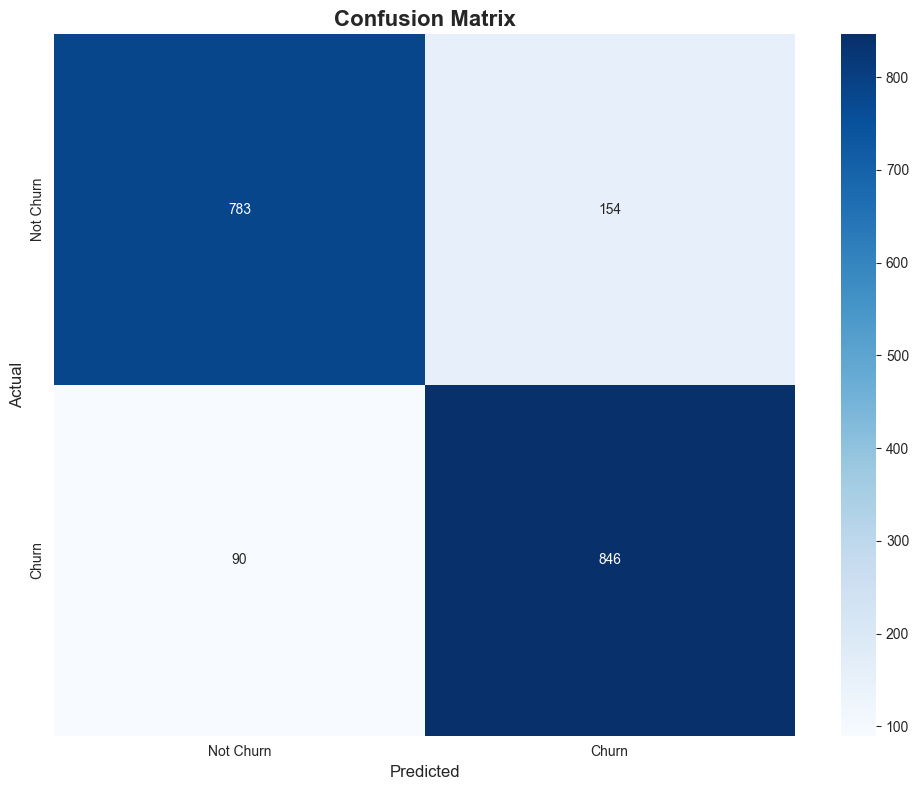


Confusion Matrix Explanation:
  True Negatives (TN): 783 - Correctly predicted non-churn customers
  False Positives (FP): 154 - Incorrectly predicted as churn (Type I error)
  False Negatives (FN): 90 - Missed churn customers (Type II error)
  True Positives (TP): 846 - Correctly predicted churn customers


In [33]:
# Confusion Matrix
print("\n" + "=" * 60)
print("STEP 8: Generating Confusion Matrix")
print("=" * 60)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n✓ Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Explain confusion matrix
print("\nConfusion Matrix Explanation:")
print(f"  True Negatives (TN): {cm[0][0]} - Correctly predicted non-churn customers")
print(f"  False Positives (FP): {cm[0][1]} - Incorrectly predicted as churn (Type I error)")
print(f"  False Negatives (FN): {cm[1][0]} - Missed churn customers (Type II error)")
print(f"  True Positives (TP): {cm[1][1]} - Correctly predicted churn customers")


## Step 9: ROC Curve

Generate and visualize the ROC curve to evaluate model performance.



STEP 9: Generating ROC Curve

✓ ROC curve saved as 'roc_curve.png'


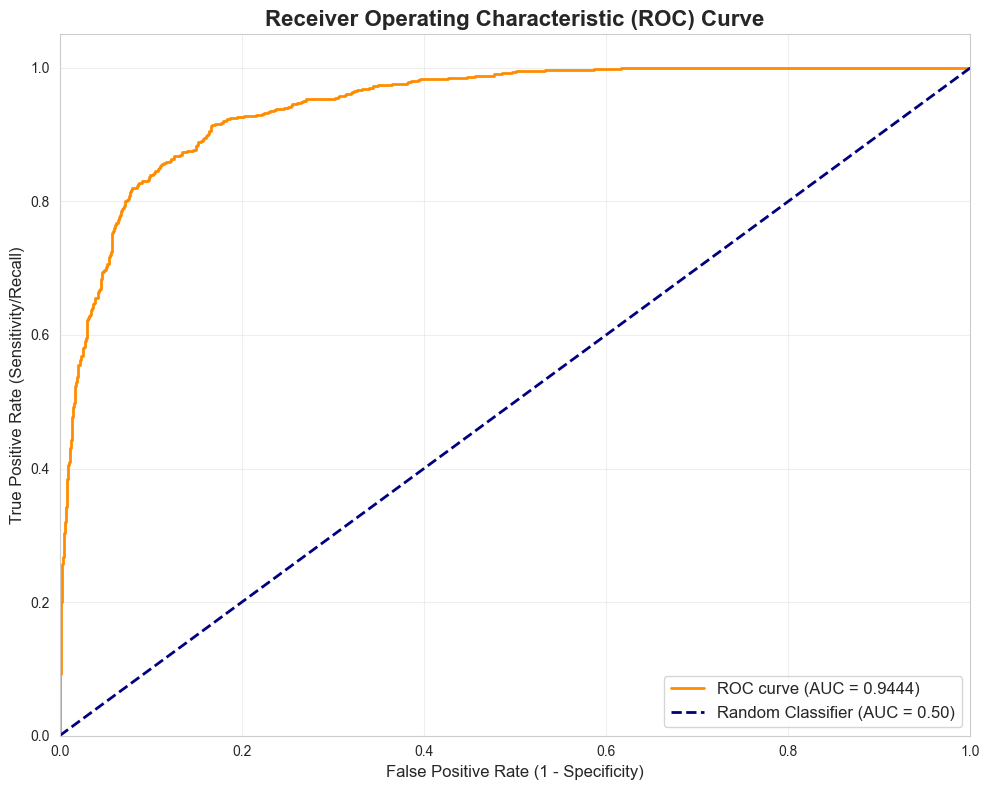


ROC Curve Explanation:
  AUC Score: 0.9444
  Interpretation: Excellent model performance

  The ROC curve shows the trade-off between:
    - True Positive Rate (TPR): Ability to correctly identify churn customers
    - False Positive Rate (FPR): Incorrectly flagging non-churn customers
  A higher AUC indicates better model performance.


In [34]:
# ROC Curve
print("\n" + "=" * 60)
print("STEP 9: Generating ROC Curve")
print("=" * 60)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
        label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
        label='Random Classifier (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
print("\n✓ ROC curve saved as 'roc_curve.png'")
plt.show()

# Explain ROC curve
print("\nROC Curve Explanation:")
print(f"  AUC Score: {roc_auc:.4f}")
if roc_auc > 0.9:
    print("  Interpretation: Excellent model performance")
elif roc_auc > 0.8:
    print("  Interpretation: Good model performance")
elif roc_auc > 0.7:
    print("  Interpretation: Moderate model performance")
else:
    print("  Interpretation: Poor model performance - needs improvement")
print("\n  The ROC curve shows the trade-off between:")
print("    - True Positive Rate (TPR): Ability to correctly identify churn customers")
print("    - False Positive Rate (FPR): Incorrectly flagging non-churn customers")
print("  A higher AUC indicates better model performance.")


## Final Summary

Summary of the complete ML pipeline and model performance.


In [ ]:
# Final Summary
print("\n" + "=" * 80)
print("FINAL MODEL EVALUATION SUMMARY")
print("=" * 80)
print(f"\nTest Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Train Accuracy:    {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"CV Mean Accuracy:  {cv_mean:.4f} ({cv_mean*100:.2f}%)")
print(f"CV Std:            {cv_std:.4f} (±{cv_std*2:.4f})")
print(f"Overfitting Gap:   {overfitting_gap:.4f}")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"ROC-AUC:           {roc_auc:.4f}")

print(f"\nPCA Dimensionality Reduction:")
print(f"  Original Features: {X.shape[1]}")
print(f"  Reduced Features:  {n_components}")
print(f"  Variance Retained: {explained_variance*100:.2f}%")

print(f"\nOverfitting Status:")
if overfitting_gap < 0.02:
    print("  ✓ Excellent: No significant overfitting")
elif overfitting_gap < 0.05:
    print("  ✓ Good: Minimal overfitting (acceptable)")
else:
    print("  ⚠ Caution: Overfitting detected - model may not generalize well")

print(f"\nCross-Validation Stability:")
if cv_std < 0.01:
    print("  ✓ Excellent: Very stable model")
elif cv_std < 0.02:
    print("  ✓ Good: Stable model")
else:
    print("  ⚠ Caution: Model variability detected")

target_accuracy = 0.87
if abs(accuracy - target_accuracy) < 0.02:
    print(f"\n✓ Target accuracy (~87%) achieved!")
else:
    print(f"\n  Current accuracy: {accuracy*100:.2f}%, Target: {target_accuracy*100:.2f}%")

print("\n" + "=" * 80)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 80)
